# Average Annual Daily Traffic (Current)

Minnesota Department of Transport (MnDoT)

Output Coordinate Reference System: UTM 15N - EPSG:26915

Source: https://gisdata.mn.gov/dataset/trans-aadt-traffic-segments

Metadata: https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dot/trans_aadt_traffic_segments/metadata/metadata.html

In [1]:
### Import Libraries

# File manipulation

import os # For working with Operating System
import urllib # For accessing websites
import zipfile # For extracting from Zipfiles
from io import BytesIO # For reading bytes objects

import psycopg2
from psycopg2 import sql, extras
import json
import requests

# Analysis

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import arcpy

# Set workspace

arcpy.env.workspace = os.path.join(os.getcwd(), 'QAQC_gdb.gdb')


# import geopandas as gpd # Spatial Data Manipulation

In [2]:
### Definitions

def extract_zip_from_url(url=None):
    '''Extract a zipfile from the internet and unpack it in to it's own folder within working directory.
    Takes a single url (string).'''
    
    if type(url) == str: # Single url
        # Create folder name for file
        folder_name = url.split('/')[-1][:-4]
        # Make folder for files
        path = os.path.join(os.getcwd(), folder_name)
        if folder_name not in os.listdir():
            os.mkdir(path)
        # Unload zip into the new folder
        response = urllib.request.urlopen(url) # Get a response
        zip_folder = zipfile.ZipFile(BytesIO(response.read())) # Read Response
        zip_folder.extractall(path=path) # Extract files
        zip_folder.close() # Close zip object
    else:
        print('Error Extracting: Invalid Input')
        
def get_boundary():
    
    # Connect to Database
    pg_connection_dict = {
    'dbname': 'MplsCommunityAir',
    'user': 'postgres',
    'password': 'postgres',
    'port': '5432',
    'host': '35.232.191.92'
    }

    conn = psycopg2.connect(**pg_connection_dict)
    
    # Create json cursor
    cur = conn.cursor()
    
    # Get the example
    cmd = """SELECT ST_AsText(geometry)
FROM PurpleAir.Minneapolis_Boundary;"""
    
    cur.execute(cmd)
    
    conn.commit() # Commit command
    
    wkt = cur.fetchone()[0]
    
    # Close connection
    cur.close()
    conn.close()
    
    return wkt

In [2]:
### Download
    
## AADT for all of Minnesota - Downloaded from MN GeospatialCommons gisdata.mn.gov  (~ 5mb)

url = 'https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dot/trans_aadt_traffic_segments/shp_trans_aadt_traffic_segments.zip'
extract_zip_from_url(url)

## Load

# Get path

folder = url.split('/')[-1][:-4] # Get folder name (last part of address minus .zip)
filename = 'Annual_Average_Daily_Traffic_Segments_in_Minnesota.shp'
path = os.path.join(folder, filename)

# Create Feature Layer

arcpy.MakeFeatureLayer_management(path, "AADT_lyr")

In [2]:
# Clip to extent

# # Load mpls boundary (for when it's up in database)

# mpls_boundary_wkt = get_boundary()
# mpls_boundary = arcpy.FromWKT(mpls_boundary_wkt, 
#                              arcpy.SpatialReference(4326))

# # Define extent

# extent = mpls_boundary.projectAs(arcpy.SpatialReference(26915)).buffer(8000)
                                 
# Clip

clipped_aadt = arcpy.Analysis.Clip('AADT_lyr', 'mpls_boundary', 'clipped_aadt')

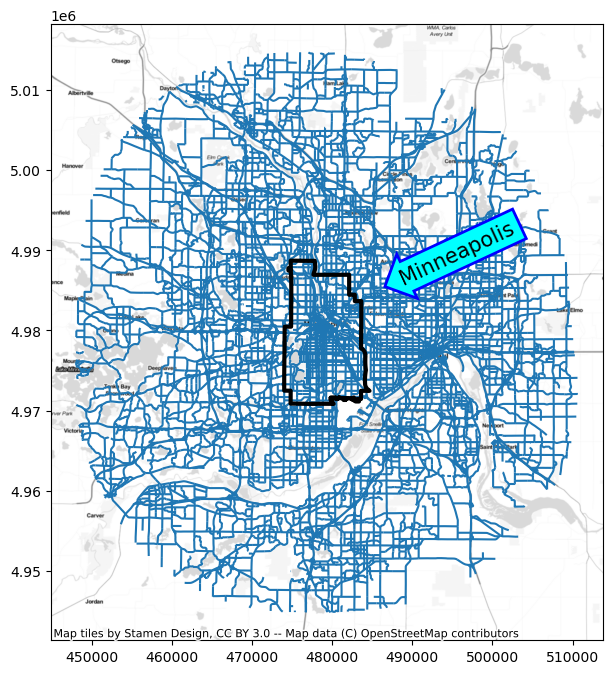

In [2]:
# Add column for WKT

arcpy.management.AddField(clipped_aadt, 'WKT', 'TEXT')
arcpy.management.CalculateField(clipped_aadt, 'WKT',
                                "!SHAPE.WKT!",
                                "PYTHON3")


# Convert to pandas dataframe

cols = ['SEQUENCE_N','ROUTE_LABE','STREET_NAM','DAILY_FACT', 'SEASONAL_F', 'AXLE_FACTO', 'CURRENT_YE','CURRENT_VO','WKT']

df = pd.DataFrame(arcpy.da.FeatureClassToNumPyArray(clipped_aadt, 
                                                      cols,
                                                      skip_nulls=False, null_value=-99999))

df = df.rename(columns = {'SEQUENCE_N':'SEQUENCE_NUMBER',
                         'ROUTE_LABE':'ROUTE_LABEL',
                          'STREET_NAM':'STREET_NAME',
                          'DAILY_FACT':'DAILY_FACTOR',
                          'SEASONAL_F':'SEASONAL_FACTOR',
                          'AXLE_FACTO':'AXLE_FACTOR',
                          'CURRENT_YE':'CURRENT_YEAR',
                          'CURRENT_VO':'CURRENT_VOLUME',
                          'WKT':'geometry'}
              )


In [ ]:
# Upload to Database

# Connect to PostGIS Database

pg_connection_dict = {
    'dbname': 'MplsCommunityAir',
    'user': 'postgres',
    'password': 'postgres',
    'port': '5432',
    'host': '35.232.191.92'
}

conn = psycopg2.connect(**pg_connection_dict)

# Create Cursor for commands

cur = conn.cursor()

# Insert into table

tuples = [tuple(x) for x in df.to_numpy()]
  
cols_string = ','.join(list(df.columns))
# SQL query to execute
query = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
cursor = conn.cursor()

for i, row in df.iterrows():
    
    vals_string = ','.join(list(row.values[:-1])) # Get all values except last one (geometry) as string for insert query
    geom_string = row.geometry
    
    cur.execute(
        'INSERT INTO PurpleAir.MNDOT_Current_AADT_Segments(%(cols)s)'
        'VALUES (%(values)s, ST_Transform(ST_SetSRID(ST_GeomFromText(%(geom)s), 26915),4326)::geometry);',
        {'cols': cols_string,
         'values': vals_string,
         'geom': geom_string}
        )

    # Commit command

    conn.commit()

# Close cursor

cur.close()

# Close connection

conn.close()